# Finding Resistivity
In the instrument calculation assignment, the resistance of the semiconductor was calculated as the slope of the I-V plot generated by the source measure unit (SMU). We can then use that measure of the resistance to find the resistivity of the chip as well, which can be found as:
$$\rho = \frac{wt}{l}R$$
Where w, t, and l describe the width, thickness, and length respectively of the chip. The thickness was provided by a label on the chip as 500 $\mu m$ - but the thickness and length are less certain. Estimating the chip to have a width of 2mm and a length of 8mm, we then need to consider that we are measuring across tabs B and C or Q and R, which represent roughly 1/3rd of the chips length. We can then use these values and the resistance to calculate the resistivity.

In [1]:
import hall_functions
import numpy as np

def calc_rho_from_R(avg_R, avg_R_sigma):
    # State R +/- R_sigma & R
    R1 = avg_R - avg_R_sigma
    R2 = avg_R
    R3 = avg_R + avg_R_sigma

    # Dimensions of wafer
    t = 5e-6 # m
    w = 0.008/3 # m
    l = 0.002 # m
    a = t*w

    # Finding rho ranges
    rho1 = a * R1 / l
    rho2 = a * R2 / l
    rho3 = a * R3 / l

    rho = rho2
    rho_sigma = rho3-rho1

    return rho, rho_sigma

In [2]:
avg_R = 174.256
avg_R_sigma = 0.014

rho, rho_sigma = calc_rho_from_R(avg_R, avg_R_sigma)
print(f'Resistivity = {rho:.8f} (Ohm meters) +/- {rho_sigma:.8f} (Ohm meters)')

Resistivity = 0.00116171 (Ohm meters) +/- 0.00000019 (Ohm meters)


# Hall effect
![diagram](images\semiconductor_diagram.png)

Our measurements to characterize the chip's resistance and resistivity were taken parallel to the electrical field present in the chip, from $B \to C$ and $Q \to R$. But in the presence of a magnetic field which is perpendicular to the electric one, charges should be deflected in the third perpendicular direction. If we call the left to right plane of the chip the x-axis and the direction of the magnetic field to be the z-axis, we should observe an accumulation of charges across the chips y-axis. In the diagram, this means we should detect a potential difference, $V_H$, across the $Q \to B$ and $R \to C$ tabs when a magnetic field is present.

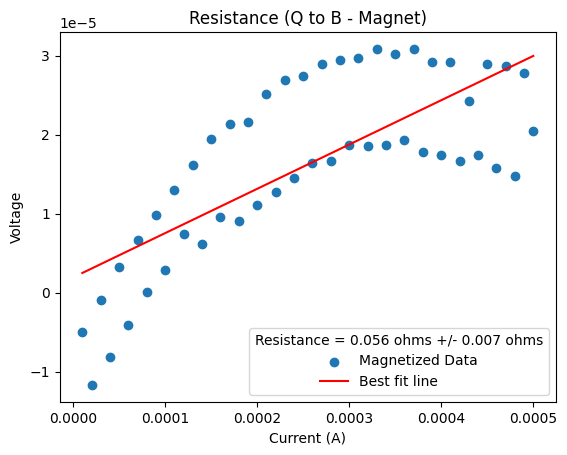

In [7]:
RHqb, RHqb_sigma = hall_functions.plot_resistance('Data/BqRbRUN10.csv', 'Q', 'B', Magnet=True)

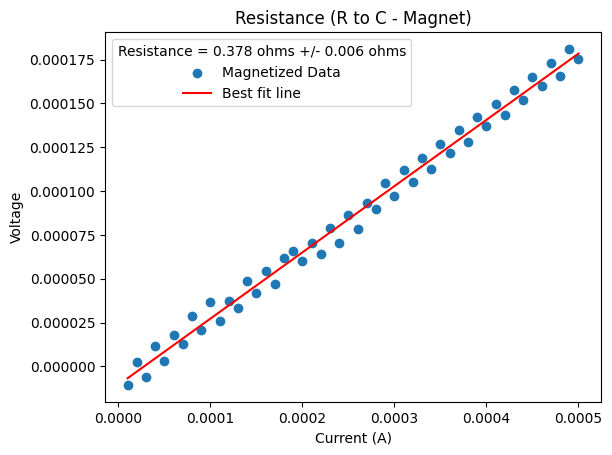

In [4]:
RHrc, RHrc_sigma = hall_functions.plot_resistance('Data/BrRcRUN8.csv', 'R', 'C', Magnet=True)

As can be seen by the non-linearity of the $Q \to B$ plot, there was likely some sort of issue which occured while taking the data across that measurement. As a result of this, only the $R \to C$ data will be used to calculate the charge density. The magnetic field the chip was placed inside of has a strength of $0.09 T \pm 0.003 T$.

The **Hall resistance** can then be written as:
$$R_H = \frac{V_H}{I} = \frac{B}{net}$$
This means that we should be able to use our data for the value of $R_H$ and our measurement for B in order to find the number density of charge carriers as:
$$n = \frac{B}{etR_H}$$ 

We will also want to perform error propagation to find the uncertainty in n. We will assume 0 uncertainty in e and t, giving us the formula:

$$\sigma_n = \sqrt{(\frac{\delta n}{\delta B})^2 \sigma^2_B + (\frac{\delta n}{\delta {R_H}})^2 \sigma^2_{R_H}}$$
$$\sigma_n = \sqrt{(\frac{1}{etR_H})^2 \sigma^2_B + (- \frac{B}{etR^2_H})^2 \sigma^2_{R_H}}$$

From there, we can determine what type of doping our chip received, using the relationship of:

P-doped, n-type Si: $n>>n_i>>p$

B-doped, p-type Si: $p>>n_i>>n$

Where $n_i$ is the number density of *intrinsic carriers*, p is the number density of holes in the Valence Band (VB) which act as positively charged carriers, and n is the number of electrons in the Conduction Band (CB).



In [26]:
e = 1.602e-19 # C
t = 5e-6 # m
w = 0.008 # m
l = 0.002 # m
B = 0.09 # T
B_sigma = 0.003 # T
n = B/(e * t * RHrc)
n_sigma = np.sqrt(((1/(e * t * RHrc))**2) * B_sigma **2 + ((B/(e * t * RHrc**2))**2) * RHrc_sigma**2)

print(f'Charge number density = {n * 1e6:.4e} +/- {n_sigma * 1e6:.4e} carriers per cubic centimeter.')

Charge number density = 2.9732e+29 +/- 1.0817e+28 carriers per cubic centimeter.


According to the paper, "Improved value for the silicon intrinsic carrier concentration at 300K" (Sproul, Green, Zhao, 1990), Silicon has an intrinsic carrier density of $1.45 \times 10^{10} cm^{-3} \pm 4.35 \times 10^{8} cm^{-3}$.

We can now use the law of mass action as well as our calculation for n to find the value of p:
$$n \cdot p = n_i^2 \to p = \frac{n_i^2}{n}$$
$$\sigma_p = \sqrt{(2\frac{n_i}{n})^2 \sigma_{n_i}^2 + (-\frac{n_i^2}{n^2})^2 \sigma_n^2}$$

In [31]:
n_i = 1.45e10
n_i_sigma = 4.35e8
p = ((n_i)**2)/n
p_sigma = np.sqrt(((2*n_i/n)**2)*(n_i_sigma**2) + ((n_i**2/n**2)**2)*(n_sigma**2))
print(f'Number density of holes in VB = {p:.6f} cm^-3 +/- {p_sigma:.6f} cm^-3')

Number density of holes in VB = 0.000707 cm^-3 +/- 0.000050 cm^-3


This tells us that our sample is likely **P-doped, n-type Si**, as $n>>n_i>>p$